In [1]:
import pandas as pd
import numpy as np
from collections import deque
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob

In [2]:
movie_titles = pd.read_csv(
    'datasets/movie_titles.csv',
    encoding='ISO-8859-1',
    header=None,
    index_col=0,  
    names=['Id', 'Year', 'Title1', 'Title2', 'Title3', 'Title4', 'Title5'],  
    engine='python'
)

movie_titles['Name'] = movie_titles[['Title1','Title2','Title3','Title4','Title5']].fillna('').agg(','.join, axis=1)
movie_titles = movie_titles.drop(columns=['Title1','Title2','Title3','Title4','Title5'])

In [3]:
print('Shape Movie-Titles:\t{}'.format(movie_titles.shape))

Shape Movie-Titles:	(17770, 2)


In [4]:
arquivos = glob.glob('datasets/combined_data_*.txt')

dfs = []
for arq in arquivos:
    df = pd.read_csv(
        arq,
        header=None,
        names=['User', 'Rating', 'Date'],
        usecols=[0, 1, 2]
    )
    dfs.append(df)

df_raw = pd.concat(dfs, ignore_index=True)

df_raw.to_csv('datasets/combined_data_all.csv', index=False)

tmp_movies = df_raw[df_raw['Rating'].isna()]['User'].reset_index()
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)


user_data = []

for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):
    
    if df_id_1<df_id_2:
        tmp_df = df_raw.loc[df_id_1+1:df_id_2-1].copy()
    else:
        tmp_df = df_raw.loc[df_id_1+1:].copy()
        
    tmp_df['Movie'] = movie_id
    
    user_data.append(tmp_df)

df = pd.concat(user_data)
del user_data, df_raw, tmp_movies, tmp_df, shifted_movie_indices, movie_indices, df_id_1, movie_id, df_id_2, next_movie_id
print('Shape User-Ratings:\t{}'.format(df.shape))
df.sample(5)

Shape User-Ratings:	(51031355, 4)


,User,Rating,Date,Movie
8725432,1474606,4.0,2004-09-29,1744
19864288,953011,4.0,2004-02-11,3798
31799997,250618,3.0,2005-06-13,5793
27531409,658498,4.0,2004-01-20,5085
8139633,1426395,3.0,2005-03-24,1629


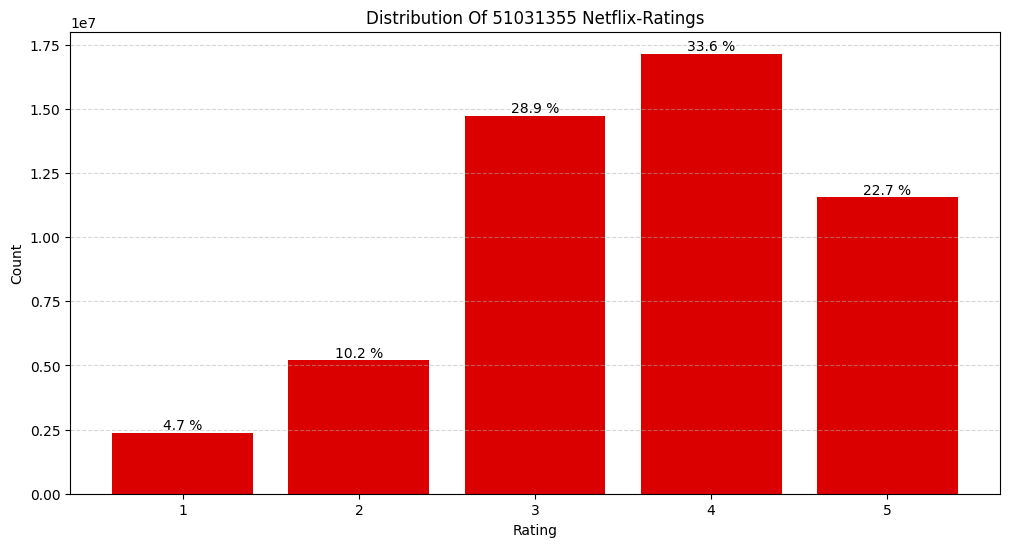

In [ ]:
data = df['Rating'].value_counts().sort_index(ascending=False)

fig, ax = plt.subplots(figsize=(12,6))
bars = ax.bar(data.index, data.values, color='#db0000')

for bar in bars:
    height = bar.get_height()
    percent = height / df.shape[0] * 100
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{percent:.1f} %', 
            ha='center', va='bottom', color='#000000')

ax.set_title(f'Distribution Of {df.shape[0]} Netflix-Ratings')
ax.set_xlabel('Rating')
ax.set_ylabel('Count')

ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

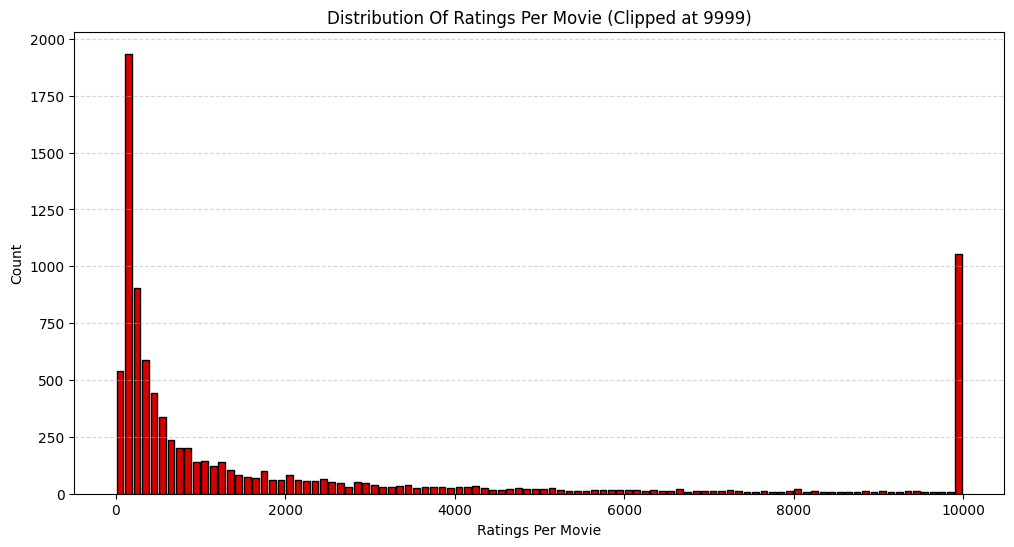

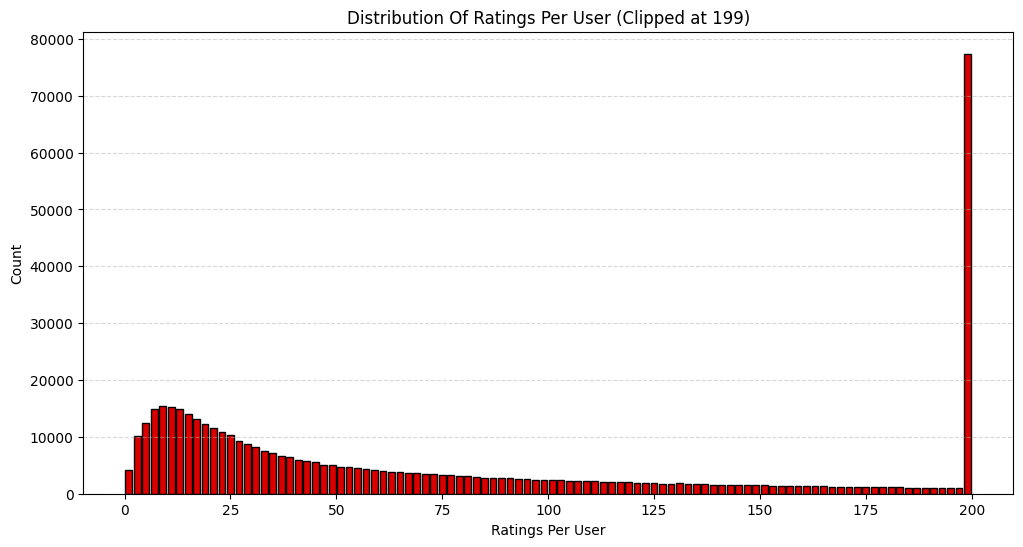

In [ ]:
data_movie = df.groupby('Movie')['Rating'].count().clip(upper=9999)

plt.figure(figsize=(12,6))
plt.hist(data_movie.values, bins=range(0, 10001, 100), color='#db0000', edgecolor='black', rwidth=0.8)
plt.title('Distribution Of Ratings Per Movie (Clipped at 9999)')
plt.xlabel('Ratings Per Movie')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


data_user = df.groupby('User')['Rating'].count().clip(upper=199)

plt.figure(figsize=(12,6))
plt.hist(data_user.values, bins=range(0, 201, 2), color='#db0000', edgecolor='black', rwidth=0.8)
plt.title('Distribution Of Ratings Per User (Clipped at 199)')
plt.xlabel('Ratings Per User')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [5]:
min_movie_ratings = 10000
filter_movies = (df['Movie'].value_counts()>min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

min_user_ratings = 200
filter_users = (df['User'].value_counts()>min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

df_filterd = df[(df['Movie'].isin(filter_movies)) & (df['User'].isin(filter_users))]
del filter_movies, filter_users, min_movie_ratings, min_user_ratings
print('Shape User-Ratings unfiltered:\t{}'.format(df.shape))
print('Shape User-Ratings filtered:\t{}'.format(df_filterd.shape))

Shape User-Ratings unfiltered:	(51031355, 4)
Shape User-Ratings filtered:	(21830456, 4)


In [6]:
df_train, df_test = train_test_split(df_filterd, test_size=0.2, shuffle=True, random_state=42)

In [7]:
from keras.layers import Input

user_id_mapping = {id:i for i, id in enumerate(df_filterd['User'].unique())}
movie_id_mapping = {id:i for i, id in enumerate(df_filterd['Movie'].unique())}


train_user_data = df_train['User'].map(user_id_mapping)
train_movie_data = df_train['Movie'].map(movie_id_mapping)

test_user_data = df_test['User'].map(user_id_mapping)
test_movie_data = df_test['Movie'].map(movie_id_mapping)


users = len(user_id_mapping)
movies = len(movie_id_mapping)
embedding_size = 10


user_id_input = Input(shape=[1], name='user')
movie_id_input = Input(shape=[1], name='movie')

2025-12-15 21:58:32.131080: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-15 21:58:32.142553: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-15 21:58:32.742311: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-15 21:58:36.459828: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [8]:
import matplotlib.pyplot as plt

def plot_learning_curves(history, filename="learning_curve.png"):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Learning Curves")
    plt.legend()
    plt.grid(True)
    plt.savefig(filename, dpi=300)
    plt.close()


In [9]:
def precision_at_k(recommended_items, relevant_items, k):
    if len(recommended_items) == 0:
        return 0.0
    recommended_k = recommended_items[:k]
    hits = len(set(recommended_k) & set(relevant_items))
    return hits / k


In [10]:
def evaluate_precision_at_k_arrays(
    model,
    test_user_data,
    test_movie_data,
    ratings,
    num_movies,
    k=10,
    threshold=4
):
    precisions = []

    test_user_data = test_user_data.astype(np.int32)
    test_movie_data = test_movie_data.astype(np.int32)

    for user_id in np.unique(test_user_data):

        mask = test_user_data == user_id
        relevant_movies = test_movie_data[
            mask & (ratings >= threshold)
        ]

        if len(relevant_movies) == 0:
            continue

        user_array = np.full(num_movies, user_id, dtype=np.int32)
        movie_array = np.arange(num_movies, dtype=np.int32)

        scores = model.predict(
            [user_array, movie_array],
            batch_size=1024,
            verbose=0
        ).flatten()

        top_k_movies = np.argsort(scores)[::-1][:k]

        hits = np.intersect1d(top_k_movies, relevant_movies)
        precisions.append(len(hits) / k)

    return float(np.mean(precisions))


In [11]:
from keras.layers import Input, Embedding, Reshape, Dense, Dropout, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import mean_squared_error


# ==============================
#          DMF MODEL
# ==============================
def get_dmf(users, movies,
            embed_dim=32,
            mlp_layers=[64, 32, 16]):

    # Inputs
    user_input = Input(shape=(1,), name='user')
    movie_input = Input(shape=(1,), name='movie')

    # Embeddings
    user_emb = Embedding(users, embed_dim)(user_input)
    movie_emb = Embedding(movies, embed_dim)(movie_input)

    # Flatten
    user_vec = Reshape((embed_dim,))(user_emb)
    movie_vec = Reshape((embed_dim,))(movie_emb)

    # Concat
    x = Concatenate()([user_vec, movie_vec])

    # MLP
    for units in mlp_layers:
        x = Dense(units, activation='relu')(x)

    # Output
    output = Dense(1)(x)

    model = Model([user_input, movie_input], output)
    model.compile(optimizer=Adam(1e-3), loss='mse')

    return model


# ==============================
#      Criar e treinar DMF
# ==============================
early = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model = get_dmf(users, movies)
model.summary()

history = model.fit(
    [train_user_data, train_movie_data],
    df_train['Rating'],
    batch_size=256,
    epochs=20,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early]
)

plot_learning_curves(history)

# ==============================
#      Testar
# ==============================
y_pred = model.predict([test_user_data, test_movie_data])
rmse = np.sqrt(mean_squared_error(df_test['Rating'], y_pred))

print(f"\nTesting Result with DMF (Keras): {rmse:.4f} RMSE")


E0000 00:00:1765814382.186152    7732 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1765814382.197975    7732 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 32)     │  2,430,048 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 32)     │     33,696 │ movie[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 32)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 32)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        528 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         17 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,470,529 (9.42 MB)

 Trainable params: 2,470,529 (9.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
61399/61399 ━━━━━━━━━━━━━━━━━━━━ 932s 15ms/step - loss: 0.7689 - val_loss: 0.7155
Epoch 2/20
61399/61399 ━━━━━━━━━━━━━━━━━━━━ 993s 16ms/step - loss: 0.6898 - val_loss: 0.6859
Epoch 3/20
61399/61399 ━━━━━━━━━━━━━━━━━━━━ 961s 16ms/step - loss: 0.6562 - val_loss: 0.6719
Epoch 4/20
61399/61399 ━━━━━━━━━━━━━━━━━━━━ 957s 16ms/step - loss: 0.6322 - val_loss: 0.6666
Epoch 5/20
61399/61399 ━━━━━━━━━━━━━━━━━━━━ 952s 15ms/step - loss: 0.6130 - val_loss: 0.6633
Epoch 6/20
61399/61399 ━━━━━━━━━━━━━━━━━━━━ 988s 16ms/step - loss: 0.5973 - val_loss: 0.6636
Epoch 7/20
61399/61399 ━━━━━━━━━━━━━━━━━━━━ 955s 16ms/step - loss: 0.5847 - val_loss: 0.6625
Epoch 8/20
61399/61399 ━━━━━━━━━━━━━━━━━━━━ 955s 16ms/step - loss: 0.5746 - val_loss: 0.6660
Epoch 9/20
61399/61399 ━━━━━━━━━━━━━━━━━━━━ 959s 16ms/step - loss: 0.5664 - val_loss: 0.6656
Epoch 10/20
61399/61399 ━━━━━━━━━━━━━━━━━━━━ 961s 16ms/step - loss: 0.5596 - val_loss: 0.6688
136441/136441 ━━━━━━━━━━━━━━━━━━━━ 321s 2ms/step

Testing Result with

In [ ]:
from keras.layers import Input, Embedding, Reshape, Dense, Dropout, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import mean_squared_error


# ==============================
#          DMF MODEL
# ==============================
def get_dmf(users, movies,
            embed_dim=32,
            mlp_layers=[64, 32, 16]):

    # Inputs
    user_input = Input(shape=(1,), name='user')
    movie_input = Input(shape=(1,), name='movie')

    # Embeddings
    user_emb = Embedding(users, embed_dim)(user_input)
    movie_emb = Embedding(movies, embed_dim)(movie_input)

    # Flatten
    user_vec = Reshape((embed_dim,))(user_emb)
    movie_vec = Reshape((embed_dim,))(movie_emb)

    # Concat
    x = Concatenate()([user_vec, movie_vec])

    # MLP
    for units in mlp_layers:
        x = Dense(units, activation='relu')(x)

    # Output
    output = Dense(1)(x)

    model = Model([user_input, movie_input], output)
    model.compile(optimizer=Adam(1e-3), loss='mse')

    return model


# ==============================
#      Criar e treinar DMF
# ==============================
early = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model = get_dmf(users, movies)
model.summary()

history = model.fit(
    [train_user_data, train_movie_data],
    df_train['Rating'],
    batch_size=256,
    epochs=20,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early]
)

plot_learning_curves(history)

# ==============================
#      Testar
# ==============================
y_pred = model.predict([test_user_data, test_movie_data])
rmse = np.sqrt(mean_squared_error(df_test['Rating'], y_pred))

print(f"\nTesting Result with DMF (Keras): {rmse:.4f} RMSE")


In [13]:
model.save("DMFModel.keras")

In [14]:
from tensorflow.keras.layers import (
    Input, Embedding, Dense, Flatten,
    Concatenate, Multiply
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


def get_ncf(users, movies,
            gmf_dim=16,
            mlp_dim=32,
            mlp_layers=[64, 32, 16]):

    # Inputs
    user_input = Input(shape=(1,), name='user')
    movie_input = Input(shape=(1,), name='movie')

    # ===== GMF =====
    user_emb_gmf = Embedding(users, gmf_dim, name="user_gmf")(user_input)
    movie_emb_gmf = Embedding(movies, gmf_dim, name="movie_gmf")(movie_input)

    user_vec_gmf = Flatten()(user_emb_gmf)
    movie_vec_gmf = Flatten()(movie_emb_gmf)

    gmf = Multiply()([user_vec_gmf, movie_vec_gmf])

    # ===== MLP =====
    user_emb_mlp = Embedding(users, mlp_dim, name="user_mlp")(user_input)
    movie_emb_mlp = Embedding(movies, mlp_dim, name="movie_mlp")(movie_input)

    user_vec_mlp = Flatten()(user_emb_mlp)
    movie_vec_mlp = Flatten()(movie_emb_mlp)

    mlp = Concatenate()([user_vec_mlp, movie_vec_mlp])

    for units in mlp_layers:
        mlp = Dense(units, activation='relu')(mlp)

    # ===== NeuMF =====
    x = Concatenate()([gmf, mlp])
    output = Dense(1, activation='linear')(x)

    model = Model([user_input, movie_input], output)
    model.compile(
        optimizer=Adam(1e-3),
        loss='mse'
    )

    return model


In [15]:
 #==============================
#      Criar e treinar NCF
# ==============================
early = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model = get_ncf(users, movies)
model.summary()

history = model.fit(
    [train_user_data, train_movie_data],
    df_train['Rating'],
    batch_size=256,
    epochs=20,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early]
)

plot_learning_curves(history, "learninCurveNCF")

# ==============================
#      Testar
# ==============================
y_pred = model.predict([test_user_data, test_movie_data])
rmse = np.sqrt(mean_squared_error(df_test['Rating'], y_pred))

print(f"\nTesting Result with DMF (Keras): {rmse:.4f} RMSE")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_mlp            │ (None, 1, 32)     │  2,430,048 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_mlp           │ (None, 1, 32)     │     33,696 │ movie[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 32)        │          0 │ user_mlp[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 32)        │          0 │ movie_mlp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64)        │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_gmf            │ (None, 1, 16)     │  1,215,024 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_gmf           │ (None, 1, 16)     │     16,848 │ movie[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,160 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16)        │          0 │ user_gmf[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 16)        │          0 │ movie_gmf[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      2,080 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 16)        │          0 │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 16)        │        528 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32)        │          0 │ multiply[0][0],   │
│ (Concatenate)       │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         33 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,702,417 (14.12 MB)

 Trainable params: 3,702,417 (14.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
61399/61399 ━━━━━━━━━━━━━━━━━━━━ 1200s 19ms/step - loss: 0.7488 - val_loss: 0.6803
Epoch 2/20
61399/61399 ━━━━━━━━━━━━━━━━━━━━ 1284s 21ms/step - loss: 0.6428 - val_loss: 0.6582
Epoch 3/20
61399/61399 ━━━━━━━━━━━━━━━━━━━━ 1354s 22ms/step - loss: 0.6080 - val_loss: 0.6508
Epoch 4/20
61399/61399 ━━━━━━━━━━━━━━━━━━━━ 1281s 21ms/step - loss: 0.5875 - val_loss: 0.6497
Epoch 5/20
61399/61399 ━━━━━━━━━━━━━━━━━━━━ 1169s 19ms/step - loss: 0.5716 - val_loss: 0.6515
Epoch 6/20
61399/61399 ━━━━━━━━━━━━━━━━━━━━ 1169s 19ms/step - loss: 0.5582 - val_loss: 0.6535
Epoch 7/20
61399/61399 ━━━━━━━━━━━━━━━━━━━━ 1169s 19ms/step - loss: 0.5465 - val_loss: 0.6573
136441/136441 ━━━━━━━━━━━━━━━━━━━━ 176s 1ms/step

Testing Result with DMF (Keras): 0.8055 RMSE


In [16]:
model.save("NCFModel.keras")

In [11]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf

def rmse_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def get_autoencoder(num_items, hidden_dims=[128,64,32], dropout=0.2):
    input_layer = Input(shape=(num_items,), name='user_ratings')
    
    # ===== ENCODER =====
    x = input_layer
    for units in hidden_dims:
        x = Dense(units, activation='relu')(x)
        x = Dropout(dropout)(x)
    encoded = x
    
    # ===== DECODER =====
    x = encoded
    for units in reversed(hidden_dims[:-1]):
        x = Dense(units, activation='relu')(x)
        x = Dropout(dropout)(x)
    
    # ===== OUTPUT =====
    output = Dense(num_items, activation='linear')(x)
    
    model = Model(input_layer, output)
    model.compile(optimizer=Adam(1e-3), loss=rmse_loss, metrics=['mae'])
    
    return model


In [12]:
import numpy as np

# Inicializa a matriz com zeros
user_item_matrix_train = np.zeros((users, movies))
user_item_matrix_test = np.zeros((users, movies))

# Preenche a matriz de treino
for row in df_train.itertuples():
    u = user_id_mapping[row.User]
    m = movie_id_mapping[row.Movie]
    user_item_matrix_train[u, m] = row.Rating

# Preenche a matriz de teste
for row in df_test.itertuples():
    u = user_id_mapping[row.User]
    m = movie_id_mapping[row.Movie]
    user_item_matrix_test[u, m] = row.Rating


In [13]:
model = get_autoencoder(num_items=movies, hidden_dims=[128, 64, 32], dropout=0.2)

history = model.fit(
    user_item_matrix_train,  
    user_item_matrix_train,  
    batch_size=32,
    epochs=150,
    validation_split=0.1,
    shuffle=True
)


E0000 00:00:1765846769.419205    8035 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1765846769.427818    8035 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/150
2136/2136 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 1.4137 - mae: 1.0074 - val_loss: 1.2375 - val_mae: 0.7954
Epoch 2/150
2136/2136 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 1.3804 - mae: 0.9695 - val_loss: 1.2306 - val_mae: 0.7579
Epoch 3/150
2136/2136 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 1.3738 - mae: 0.9600 - val_loss: 1.2273 - val_mae: 0.7576
Epoch 4/150
2136/2136 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 1.3706 - mae: 0.9552 - val_loss: 1.2262 - val_mae: 0.7582
Epoch 5/150
2136/2136 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 1.3682 - mae: 0.9523 - val_loss: 1.2252 - val_mae: 0.7419
Epoch 6/150
2136/2136 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 1.3665 - mae: 0.9502 - val_loss: 1.2239 - val_mae: 0.7453
Epoch 7/150
2136/2136 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 1.3648 - mae: 0.9485 - val_loss: 1.2227 - val_mae: 0.7416
Epoch 8/150
2136/2136 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 1.3631 - mae: 0.9469 - val_loss: 1.2201 - val_mae: 0.7439
Epoch 9/150
2136/2136 ━━

In [14]:
plot_learning_curves(history, "learningCurveAE")